In [8]:
from models import GradCAM, MainModel
import torch
from data import ct_mean, ct_std
from argparse import Namespace
import numpy as np
from skimage.io import imsave, imread
import os

In [9]:
# grayscale to jet
def jet(image):
    n = 4 * image[:, :1]
    r = torch.clamp(torch.min(n-1.5,-n+4.5), 0, 1)
    g = torch.clamp(torch.min(n-0.5,-n+3.5), 0, 1)
    b = torch.clamp(torch.min(n+0.5,-n+2.5), 0, 1)
    return torch.cat((r,g,b), 1)


def main(opts):
    # load image and convert to tensor
    image = imread(os.path.join(opts.data_dir, 'images', '%s.png' % opts.img_id))
    image = torch.tensor(image[None, None, ...], dtype=torch.float32) / 255
    image = (image - ct_mean) / ct_std
    image = image.expand(-1, 3, -1, -1)
    ind = torch.tensor([[opts.ind]])
    # construct CNN model
    
    model = MainModel(opts.arch, 6)
    # load weights
    model.load_state_dict(torch.load('model_rn1.pt'))
    # Grad CAM
    grad_cam = GradCAM(model)
    cam = grad_cam(image, ind)
    # output image with cam
    cam = jet(cam)
    image = torch.clamp(image * ct_std + ct_mean, 0, 1)
    imsave('%s.png' % opts.img_id, np.around(image[0,0].cpu().numpy()*255).astype(np.uint8))
    image = image + cam
    image = np.moveaxis(image[0].cpu().numpy(), 0, 2)
    image = image / image.max()
    image = np.around(image*255).astype(np.uint8)
    imsave('%s-cam.png' % opts.img_id, image)

if __name__ == '__main__':
    opts = Namespace(
        data_dir = '../',
        use_gpu = False,
        arch = 'resnet101',
        img_id = '39a1e36d9',
        ind = 2
    )
    main(opts)

In [10]:
opts.img_id

'39a1e36d9'

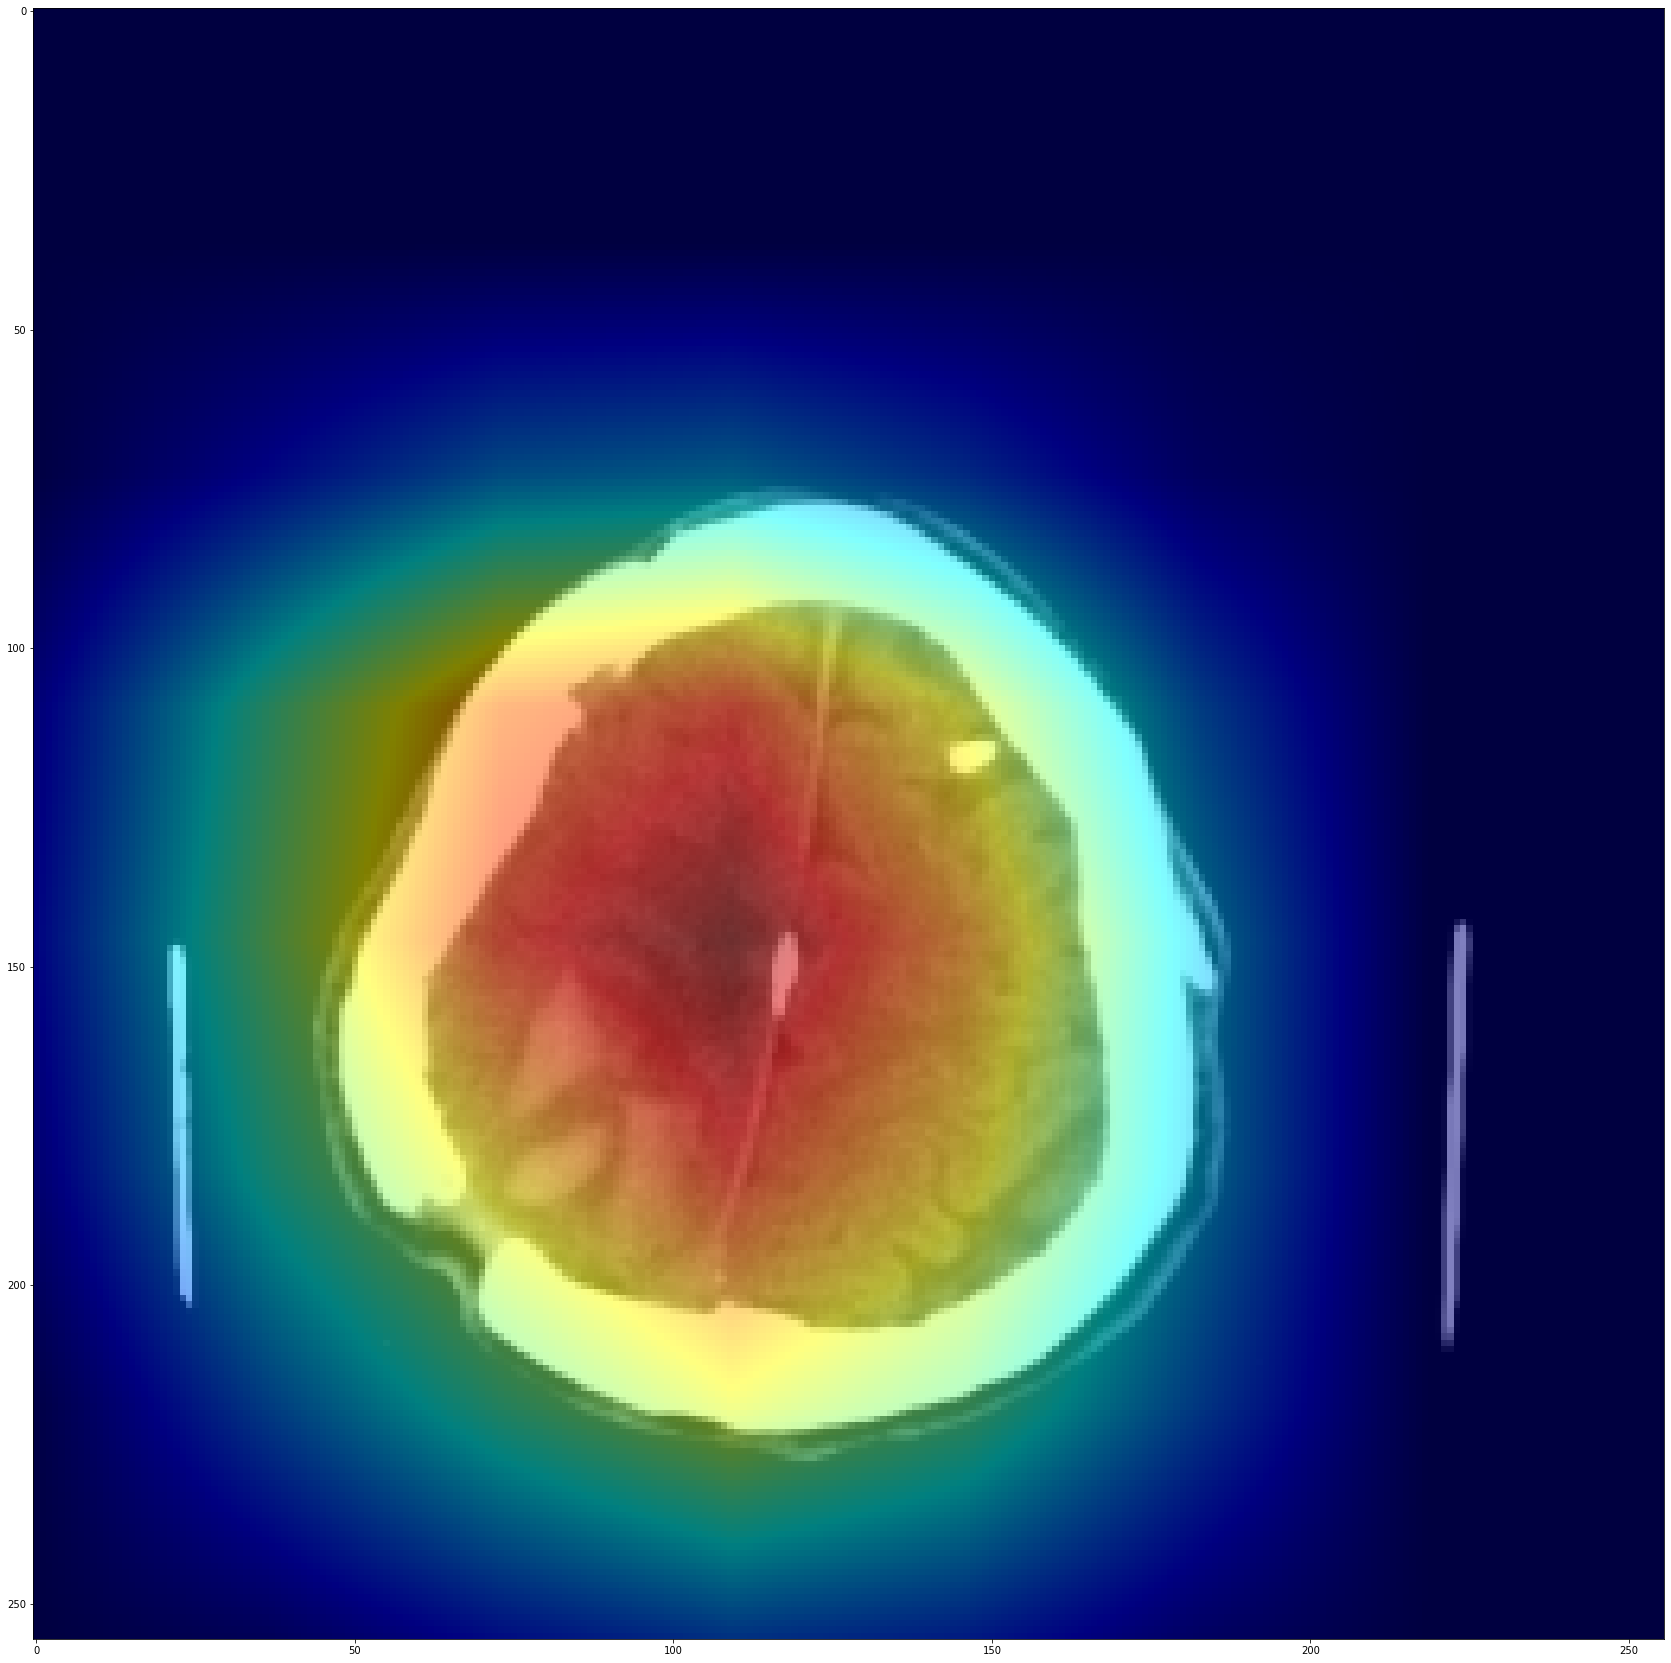

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(imread('39a1e36d9-cam.png'))